In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Sequence

image1 = plt.imread("1.jpg")
image2 = plt.imread("2.jpg")


def show_images(*args, **kwargs):
    fig, axes = plt.subplots(math.ceil(len(args) / 2), 2, figsize=(8,6))
    plt.subplots_adjust(wspace=0.1)
    if len(axes.shape) < 2:
        axes = axes[np.newaxis, :]
    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.axis('off')
            if 2 * i + j >= len(args):
                break
            tpl = args[2 * i + j]
            if isinstance(tpl, Sequence):
                col.imshow(tpl[0], **kwargs)
                if len(tpl) == 2:
                    col.set_title(tpl[1])
            else:
                col.imshow(tpl, **kwargs)
    plt.tight_layout()
    plt.show()


# Canny算法实现

## 原图展示
本次实验使用了两张图片，在之后的流程中，主要以第一张图为主。

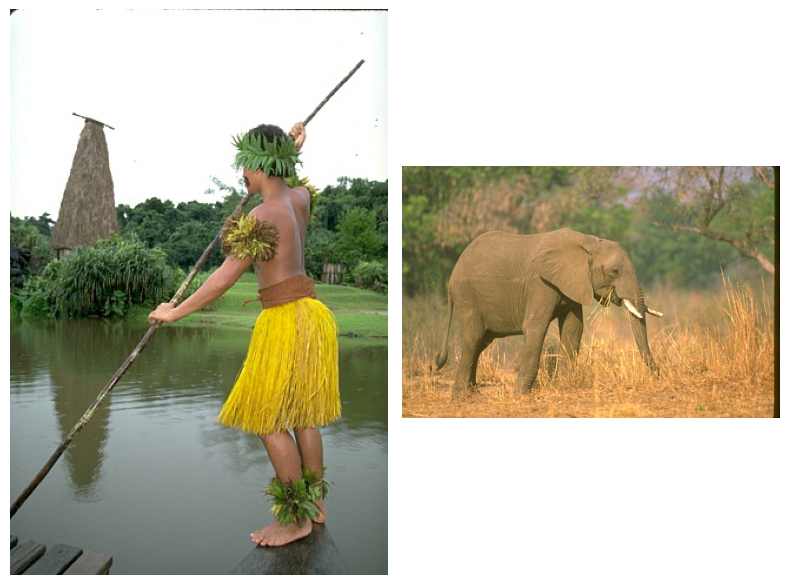

In [4]:
show_images(image1, image2)

## 彩色图像转灰度图
使用两种标准下的灰度转换公式，即

0.299 * R + 0.587 * G + 0.114 * B

和

0.2126 * R + 0.7152 * G + 0.0722 * B

之后的步骤中使用前者产生的图像。


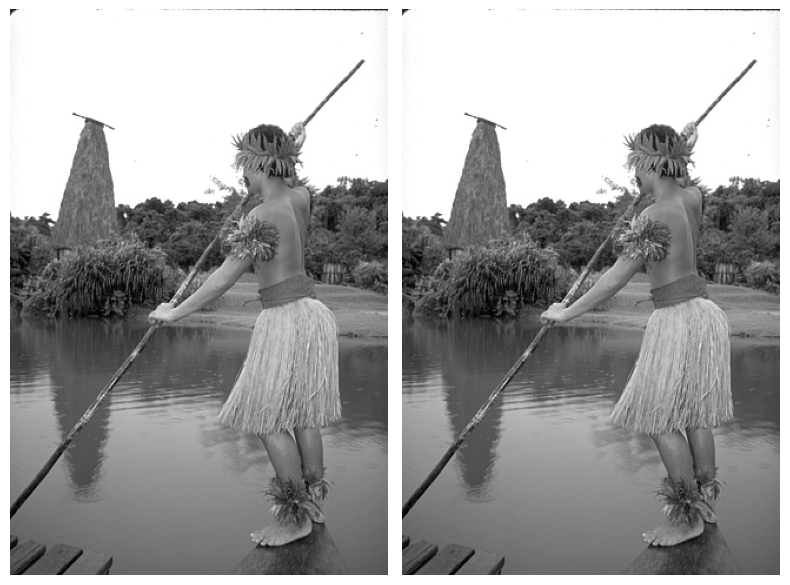

In [5]:
gray_image1_1 = np.dot(image1[..., :3], [0.299, 0.587, 0.114])
gray_image1_2 = np.dot(image1[..., :3], [0.2126, 0.7152, 0.114])
show_images(gray_image1_1, gray_image1_2, cmap="gray")
gray_image1_1 = np.uint8(gray_image1_1)

## 生成Sobel滤波器和高斯一阶差分滤波器并计算梯度

- `sobel_kernel`：该函数返回两个Sobel算子，一个用于检测水平边缘（sobel_x），另一个用于检测垂直边缘（sobel_y）。

- `gaussian_kernel`：该函数返回一个高斯卷积核。该函数接受两个参数，`ksize`表示卷积核的大小，必须是奇数，`sigma`表示高斯函数的标准差。

- `first_derivative_gaussian_kernel`：该函数返回一阶高斯卷积核。这两个卷积核可以用于检测图像的一阶导数（也就是图像的梯度）。

- `convolve`：这个函数执行卷积操作，它接受一个图像和一个卷积核作为输入，然后返回卷积后的图像。

- `image_gradient`：该函数计算图像的梯度。它接受一个图像和两个卷积核（一个用于x方向，一个用于y方向）作为输入，然后返回x, y方向的图像梯度的。


In [6]:
def sobel_kernel():
    # Sobel operator for detecting horizontal edges
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float64)

    # Sobel operator for detecting vertical edges
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float64)

    return sobel_x, sobel_y


def gaussian_kernel(ksize, sigma=None):
    assert ksize % 2 == 1, "Kernel size must be odd."
    if sigma is None or sigma <= 0:
        sigma = 0.3 * ((ksize - 1) * 0.5 - 1) + 0.8
    kernel_1d = np.linspace(-(ksize // 2), ksize // 2, ksize)

    # calculate the Gaussian function
    kernel_1d = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-kernel_1d**2 /
                                                            (2 * sigma**2))

    # normalize the kernel so that the sum of all elements is 1
    kernel_1d /= kernel_1d.sum()

    # create a 2D Gaussian kernel by taking the outer product of the 1D kernel with itself
    kernel_2d = np.outer(kernel_1d, kernel_1d)

    return kernel_2d


def first_derivative_gaussian_kernel(ksize, sigma=None):
    assert ksize % 2 == 1, "Kernel size must be odd."
    if sigma is None or sigma <= 0:
        sigma = 0.3 * ((ksize - 1) * 0.5 - 1) + 0.8

    axis = np.linspace(-(ksize // 2), ksize // 2, ksize)
    gaussian_first_derivative = -(axis /
                                  (sigma**2)) * np.exp(-0.5 * (axis**2) /
                                                       (sigma**2))

    # create 2D kernels for x and y directions
    kernel_x = np.outer(gaussian_first_derivative, np.ones(ksize))
    kernel_y = np.outer(np.ones(ksize), gaussian_first_derivative)

    return kernel_x, kernel_y


def convolve(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Create a padded copy of the image to handle edges
    padded_image = np.pad(image,
                          ((pad_height, pad_height), (pad_width, pad_width)),
                          mode='reflect')

    output = np.zeros_like(image)

    for i in range(image_height):
        for j in range(image_width):
            output[i, j] = np.sum(
                padded_image[i:i + kernel_height, j:j + kernel_width] * kernel)

    return output


def image_gradient(image, kernel_x, kernel_y):
    gradient_x = convolve(np.float64(image), kernel_x)
    gradient_y = convolve(np.float64(image), kernel_y)

    return gradient_x, gradient_y


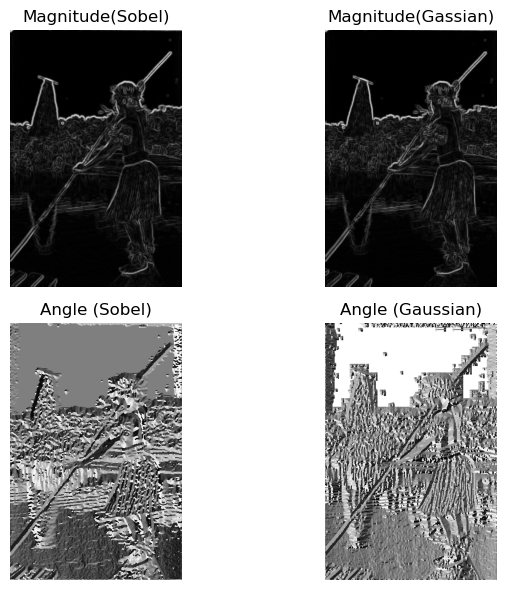

In [8]:
sobel_x, sobel_y = sobel_kernel()
g_kernel = gaussian_kernel(ksize=5)
dg_x, dg_y = first_derivative_gaussian_kernel(ksize=5)

# sobel
blurred_image = convolve(gray_image1_1, g_kernel)
sobel_grad_x, sobel_grad_y = image_gradient(blurred_image,
                                            kernel_x=sobel_x,
                                            kernel_y=sobel_y)

sobel_magitude = np.sqrt(sobel_grad_x**2 + sobel_grad_y**2)
sobel_angle = np.arctan2(sobel_grad_y, sobel_grad_x)

# first derivative gassian filter
gaussian_grad_x, gaussian_grad_y = image_gradient(gray_image1_1,
                                                  kernel_x=dg_x,
                                                  kernel_y=dg_y)
gaussian_magitude = np.sqrt(gaussian_grad_x**2 + gaussian_grad_y**2)
gaussian_angle = np.arctan2(gaussian_grad_y, gaussian_grad_x)

show_images([sobel_magitude, "Magnitude(Sobel)"],
            [gaussian_magitude, "Magnitude(Gassian)"],
            [sobel_angle, "Angle (Sobel)"],
            [gaussian_angle, "Angle (Gaussian)"],
            cmap="gray")


## 非极大值抑制
在这一步中将会使得边缘变细

In [9]:
def NMS(grad_x, grad_y, magnitude):
    ret = np.zeros_like(grad_x)
    height, width = grad_x.shape
    if magnitude is None:
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
    g = magnitude
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if grad_x[i, j] == 0:
                g_a = g[i, j - 1]
                g_b = g[i, j + 1]
            elif grad_y[i, j] == 0:
                g_a = g[i - 1, j]
                g_b = g[i + 1, j]
            elif abs(grad_y[i, j]) > abs(grad_x[i, j]):  # case (a) (b)
                w = abs(grad_x[i, j]) / abs(grad_y[i, j])
                if grad_x[i, j] * grad_y[i, j] > 0:  # case (a)
                    g_a = w * g[i - 1, j - 1] + (1 - w) * g[i - 1, j]
                    g_b = w * g[i + 1, j + 1] + (1 - w) * g[i + 1, j]
                else:  # case (b)
                    g_a = w * g[i - 1, j + 1] + (1 - w) * g[i - 1, j]
                    g_b = w * g[i + 1, j - 1] + (1 - w) * g[i + 1, j]
            else:  # case (c) (d)
                w = abs(grad_y[i, j]) / abs(grad_x[i, j])
                if grad_x[i, j] * grad_y[i, j] > 0:  # case (c)
                    g_a = w * g[i - 1, j - 1] + (1 - w) * g[i, j - 1]
                    g_b = w * g[i + 1, j + 1] + (1 - w) * g[i, j + 1]
                else:  # case (d)
                    g_a = w * g[i + 1, j - 1] + (1 - w) * g[i, j - 1]
                    g_b = w * g[i - 1, j + 1] + (1 - w) * g[i, j + 1]

            # If the magnitude is the local maximum, copy it to the output
            if g[i, j] >= max(g_a, g_b):
                ret[i, j] = g[i, j]
    return ret



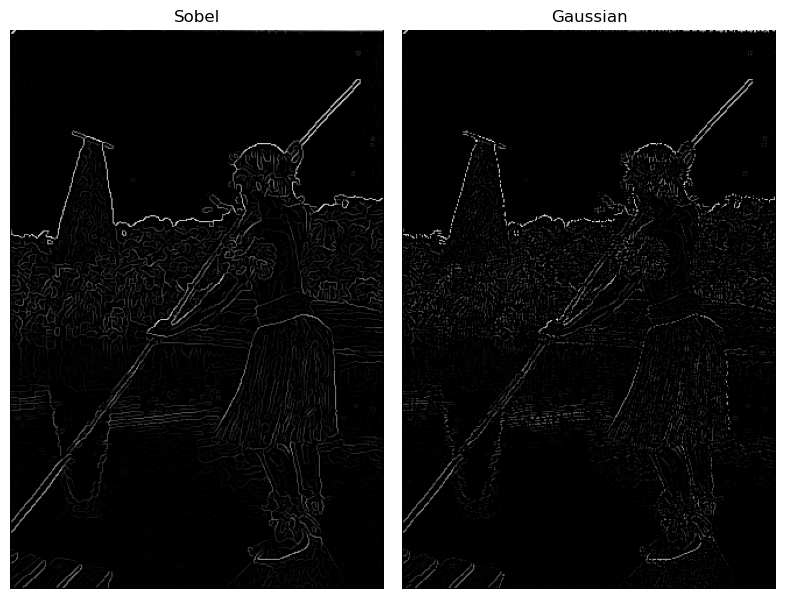

In [10]:
sobel_nms = NMS(sobel_grad_x, sobel_grad_y, sobel_magitude)
gaussian_nms = NMS(gaussian_grad_x, gaussian_grad_y, gaussian_magitude)
show_images((sobel_nms, "Sobel"), (gaussian_nms, "Gaussian"), cmap="gray")

## 滞后阈值
这一步将剔除假边缘，连接破碎的边缘，得到一张二值图像

In [11]:
def hysteresis_threshold(img, low_threshold, high_threshold):
    # Initialize the output image as a binary image with all zeros
    output = np.zeros(img.shape, dtype=np.uint8)

    # Find the starting pixel (i.e., the pixel with intensity > high_threshold)
    strong_i, strong_j = np.where(img >= high_threshold)

    # Use a stack to perform depth-first search from the starting pixel
    stack = list(zip(strong_i, strong_j))

    while len(stack) > 0:
        i, j = stack.pop()

        # If the pixel is valid and has not been visited yet
        if 0 <= i < img.shape[0] and 0 <= j < img.shape[1] and output[i,
                                                                      j] == 0:
            output[i, j] = 255

            # Find the neighboring pixel (i.e., the pixel with intensity > low_threshold)
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    if (0 <= i + di < img.shape[0]) and (
                            0 <= j + dj < img.shape[1]
                    ) and img[i + di, j + dj] >= low_threshold:
                        stack.append((i + di, j + dj))

    return output


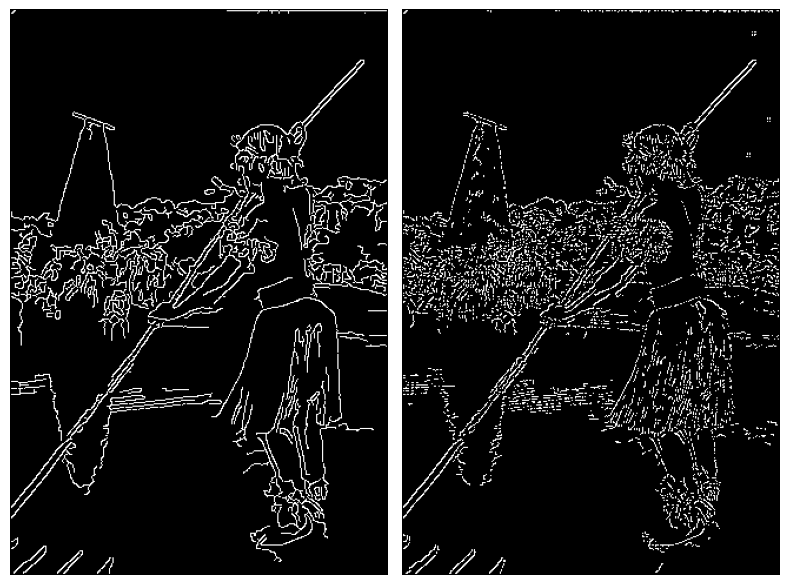

In [12]:
low_threshold = 30
high_threshold = 100
sobel_res = hysteresis_threshold(sobel_nms, low_threshold, high_threshold)
gaussian_res = hysteresis_threshold(gaussian_nms, low_threshold, high_threshold)

show_images(sobel_res, gaussian_res, cmap="gray")

## 与OpenCV的对比

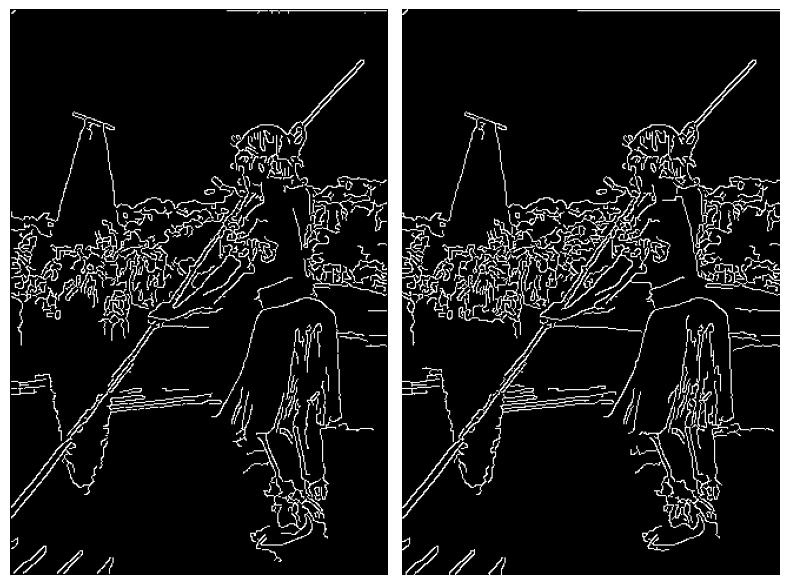

In [13]:
import cv2

opencv_res = cv2.Canny(blurred_image, low_threshold, high_threshold ,L2gradient=True, apertureSize=3)
show_images(sobel_res, opencv_res, cmap='gray')